In [59]:
# Huskeliste

# Hvordan legge til bilder i Markdown? 
# Vanlig måte: ![Tekst som vises hvis bilde ikke laster inn](images/bilde man vil ha)
# Hvis man skal bestemme størrelsen selv: <img src="images/timeline_one.jpeg" alt="Timeline" width="700">
# Hvordan skrive i grønt: <span style="color:#008000">SOLUTION 2 B.</span>

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.optimize import fsolve
import numpy_financial as npf



In [61]:
# Import of datasets
df_tbills = pd.read_csv("Datasets/treasury_bills_clean.csv")
df_bonds = pd.read_csv("Datasets/treasury_bonds_clean.csv")

# Scale PAR to $1000
df_bonds[["Bid", "Asked"]] = df_bonds[["Bid", "Asked"]] * 10

print(df_tbills.head())
print(df_bonds.head())

     Maturity    Bid  Asked    Chg  Asked Yield
0  16.09.2025  4.265  4.255  0.030        4.316
1  18.09.2025  4.250  4.240  0.025        4.302
2  23.09.2025  4.205  4.195  0.010        4.259
3  25.09.2025  4.125  4.115 -0.020        4.178
4  30.09.2025  4.125  4.115 -0.020        4.181
     Maturity  Coupon      Bid    Asked    Chg  Asked Yield
0  15.09.2025    3.50   993.10  1000.00  0.000        3.470
1  30.09.2025    0.25   992.46   992.56  0.002        4.265
2  30.09.2025    3.00   992.92   993.02  0.000        4.097
3  30.09.2025    5.00  1000.06  1000.16  0.000        3.833
4  15.10.2025    4.25  1000.00  1000.10  0.000        3.866


In [62]:
# Get BEY as of 30.12.2025 
BEY1 = (df_tbills.loc[df_tbills["Maturity"] == "30.12.2025", "Asked Yield"].iloc[0])/100

print(BEY1)


0.03955


In [63]:
# Get semi annual rate and convert to decimal for the calculation
semi_annuall_yield = ((BEY1/2))

print(semi_annuall_yield)

0.019775


In [64]:
today = pd.to_datetime("11.09.2025", format="%d.%m.%Y")
maturity_date_tbill = pd.to_datetime("30.12.2025", format="%d.%m.%Y")

def days_30_360(start, end):
    d1, m1, y1 = start.day, start.month, start.year
    d2, m2, y2 = end.day, end.month, end.year
    if d1 == 31: d1 = 30
    if d2 == 31: d2 = 30
    return 360*(y2 - y1) + 30*(m2 - m1) + (d2 - d1)

days_to_maturity_tbill = days_30_360(today, maturity_date_tbill)

print(days_to_maturity_tbill)


109


In [65]:
# Our objective is to find r110 days (r1)
# To do this we create a function to calculate the value of r1 based on the parameters we already know
# 6 months = 182,5 days

# Deifne number of days in 6 months
half_year_days = 180

def convert_to_shorter_rate(r_6m, D):
    return (1 + r_6m)**(D/half_year_days) - 1

r1 = round(convert_to_shorter_rate(semi_annuall_yield, days_to_maturity_tbill), 7)
print("r1: ",r1*100, "%")

r1:  1.19286 %


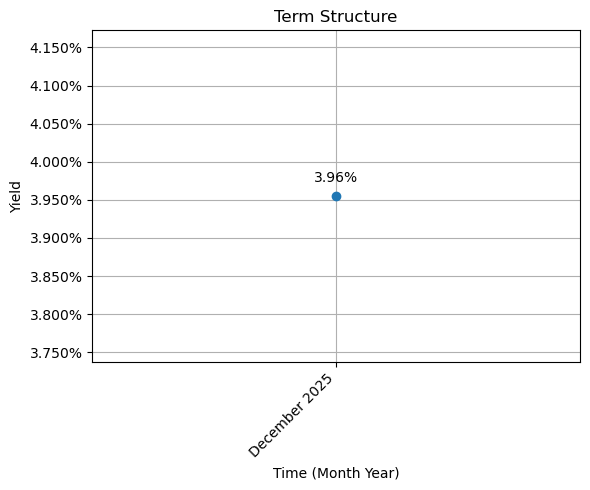

In [66]:
def plot_term_structure(labels, values, title="Term Structure"):
    """
    labels: list of strings
    values: list of yields in decimals
    """
    plt.figure(figsize=(6,5))
    plt.plot(labels, values, marker="o", linestyle="-")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
    plt.title(title)
    plt.xlabel("Time (Month Year)")
    plt.ylabel("Yield")
    plt.grid(True)

    # Rotates labes to ensure everything fits
    plt.xticks(rotation=45, ha="right")

    # Annotate the points with the yield values
    for i, val in enumerate(values):
        plt.annotate(f"{val*100:.2f}%", (labels[i], values[i]),
                     textcoords="offset points", xytext=(0,10), ha="center")

    plt.tight_layout()  # ensure everything fits
    plt.show()


# x-akse label
x_labels = ["December 2025"]
y_vals   = [BEY1]

plot_term_structure(x_labels, y_vals)

In [67]:
days_to_second_maturity = days_30_360(pd.to_datetime("11.09.2025", format="%d.%m.%Y"), pd.to_datetime("30.06.2026", format="%d.%m.%Y")) 

print(days_to_second_maturity)


289


In [68]:
# Compute the Accrued Interest of Bond 2
# Identify all bonds with maturity 30.06.2026: 

bonds_june = df_bonds.loc[df_bonds["Maturity"] == "30.06.2026"]

print(bonds_june)

      Maturity  Coupon      Bid    Asked    Chg  Asked Yield
41  30.06.2026   0.875   972.34   972.44  0.010        3.739
42  30.06.2026   1.875   981.60   981.70  0.004        3.756
43  30.06.2026   4.625  1002.10  1002.20  0.008        3.737


In [69]:
# There are three bonds with maturity date 30.06.2026, we choose the bond with the highest coupon
print(bonds_june.loc[43])

Maturity       30.06.2026
Coupon              4.625
Bid                1002.1
Asked              1002.2
Chg                 0.008
Asked Yield         3.737
Name: 43, dtype: object


In [70]:
# Calculate Accrued Interest and Dirty Price
# The coupon rate is expressed in annualized terms, hence we adjust to semiannual rate

coupon_payment = ((4.625/100)*1000)/2

clean_price = 1002.2 

# To calculate accrued interest we need to count the number of days since the last coupon payment
days_since_last_coupon = days_30_360(pd.to_datetime("30.06.2025", format="%d.%m.%Y"), today)

coupon_period_fraction = days_since_last_coupon / half_year_days

print("days_since_last_coupon:", days_since_last_coupon)
print("clean price:", clean_price)
print("coupon payment:", coupon_payment)
print("coupon period fraction: ", coupon_period_fraction)

days_since_last_coupon: 71
clean price: 1002.2
coupon payment: 23.125
coupon period fraction:  0.39444444444444443


In [71]:
# Now we have all the information we need to compute the accrued interest

accrued_interest = coupon_payment * coupon_period_fraction

print(round(accrued_interest, 5))

9.12153


In [72]:
# Now we can calculate the dirty price

dirty_price = clean_price + accrued_interest

print(round(dirty_price, 5))

1011.32153


In [73]:
# I would use the rate of the ZCB (the risk free rate) from today to the first coupon payment. 
# In semiannual terms this is essentially the BEY of the ZCB divided by two.

print((BEY1/2*100), "%")

1.9775 %


In [74]:
# We use r1 from 1B to discount the first cash flow

print("discount rate from today to first coupon payment:", r1*100, "%") 

discount rate from today to first coupon payment: 1.19286 %


In [75]:
PV_CF1 = coupon_payment/(1+r1)

print(round(PV_CF1, 5))

22.8524


In [76]:
# Since the dirty price of bond 2 is known, the no-arbitrage condition implies that the present value of the artificial bond paying only the second cash flow must equal the dirty price minus the present value of the first cash flow.

price_artifical_bond2 = dirty_price - PV_CF1

print(round(price_artifical_bond2, 5))


988.46912


In [77]:
# YTM of the second "artifical" bond consisting of the stripped last coupon and par value represents r2

CF2 = coupon_payment + 1000

r2 = (CF2 - price_artifical_bond2)/price_artifical_bond2

print("r2:", round(r2*100, 5), "%")

r2: 3.50601 %


In [78]:
# The YTM covers the period: 
days_to_maturity_bond2 = days_30_360(today, pd.to_datetime("30.06.2026", format="%d.%m.%Y"))

# We define a function to convert r2 to a semiannual rate
def convert_to_6m(r_bond, D):
    return (1 + (r_bond))**(half_year_days/D) - 1 

r_bond2_semiannual = convert_to_6m(r2, days_to_maturity_bond2)

print(round(r_bond2_semiannual*100, 5), "%")
print(days_to_maturity_bond2)

2.16947 %
289


In [79]:
BEY2 = r_bond2_semiannual*2

print(round(BEY2*100, 5), "%")

4.33893 %


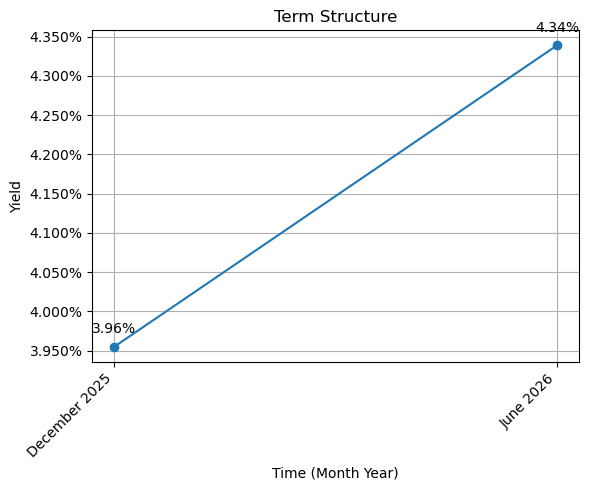

In [80]:
x_labels = ["December 2025", "June 2026"]
y_vals = [BEY1, BEY2]

plot_term_structure(x_labels, y_vals)



In [81]:
# Compute the Accrued Interest of Bond 3
# Identify all bonds with maturity 31.12.2026: 
bonds_t3 = df_bonds.loc[df_bonds["Maturity"] == "31.12.2026"]

print(bonds_t3)

      Maturity  Coupon      Bid    Asked    Chg  Asked Yield
69  31.12.2026    1.25   963.12   970.02  0.016        3.628
70  31.12.2026    1.75   971.96   972.06  0.010        3.618
71  31.12.2026    4.25  1002.34  1002.44  0.008        3.638


In [82]:
# There are three bonds with maturity date 30.06.2026, in accordance with the assignment description we choose the bond with the highest coupon
print(bonds_t3.loc[71])

Maturity       31.12.2026
Coupon               4.25
Bid               1002.34
Asked             1002.44
Chg                 0.008
Asked Yield         3.638
Name: 71, dtype: object


In [83]:
# Calculate Accrued Interest and Dirty Price
# The coupon rate is expressed in annualized terms, hence we adjust to semiannual rate
coupon_payment_bond3 = ((4.25/100)*1000)/2
clean_price_bond3 = 1002.44 

# We do not need to calculate the coupon period fraction again. This will be the same as for bond 2. 
print("days_since_last_coupon:", days_since_last_coupon)
print("clean price:", clean_price_bond3)
print("coupon payment", coupon_payment_bond3)
print("coupon period fraction: ", coupon_period_fraction)

days_since_last_coupon: 71
clean price: 1002.44
coupon payment 21.25
coupon period fraction:  0.39444444444444443


In [84]:
# Now we have all the information we need to compute the accrued interest
accrued_interest_bond3 = coupon_payment_bond3 * coupon_period_fraction

print(round(accrued_interest_bond3, 2))

8.38


In [85]:
Dirty_price_bond3 = clean_price_bond3 + accrued_interest_bond3

print(Dirty_price_bond3)

1010.8219444444445


In [86]:
PV_CF1_bond3 = coupon_payment_bond3/(1+r1)

print(round(PV_CF1_bond3, 5))

20.99951


In [87]:
PV_CF2_bond3 = coupon_payment_bond3/(1+r2)

print(round(PV_CF2_bond3, 5))

print(PV_CF1_bond3 + PV_CF2_bond3)

20.53021
41.529713149755395


In [88]:
# Since the dirty price of bond 2 is known, the no-arbitrage condition implies that the present value of the artificial bond paying only the second cash flow must equal the dirty price minus the present value of the first cash flow.
price_artifical_bond3 = Dirty_price_bond3 - PV_CF1_bond3 - PV_CF2_bond3

print(round(price_artifical_bond3, 5))

969.29223


In [89]:
# YTM of the third "artifical" bond consisting of the stripped last coupon and par value represents r3
CF3_bond3 = coupon_payment_bond3 + 1000

r3 = (CF3_bond3 - price_artifical_bond3)/price_artifical_bond3

print(round(r3*100, 5), "%")

5.36038 %


In [90]:
# Solution 3g
# The YTM covers the period: 
days_to_maturity_bond3 = days_30_360(today, pd.to_datetime("31.12.2026", format="%d.%m.%Y"))

print(days_to_maturity_bond3)


469


In [91]:
r_bond3_semiannual = convert_to_6m(r3, days_to_maturity_bond3)

print(round(r_bond3_semiannual*100, 5), "%")

2.02426 %


In [92]:
BEY3 = r_bond3_semiannual*2

print(round(BEY3*100, 5), "%")

4.04852 %


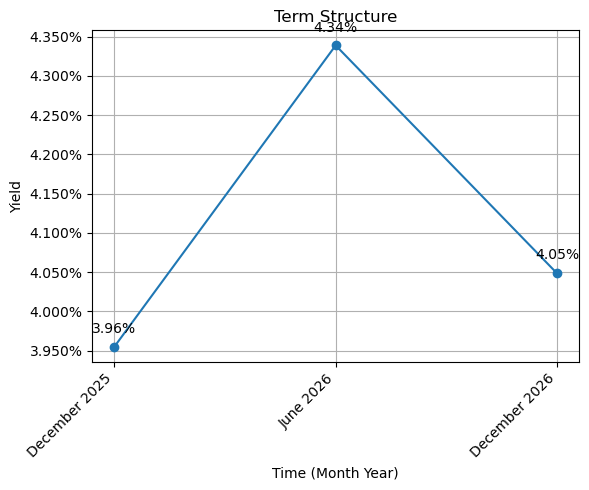

In [93]:
x_labels = ["December 2025", "June 2026", "December 2026"]
y_vals = [BEY1, BEY2, BEY3]

plot_term_structure(x_labels, y_vals)

In [94]:
# Identify all bonds from 2027 to 2030: 
df_bonds["Maturity"] = pd.to_datetime(df_bonds["Maturity"], format="%d.%m.%Y")

dates = pd.to_datetime([
    "30.06.2027", "31.12.2027",
    "30.06.2028", "31.12.2028",
    "30.06.2029", "31.12.2029",
    "30.06.2030", "31.12.2030"
], format="%d.%m.%Y")

bonds_t4_to_t10 = df_bonds[df_bonds["Maturity"].isin(dates)]

# Create a new dataframe with only the bond with the highest coupon per maturity
bonds_highest_coupon = bonds_t4_to_t10.loc[
    bonds_t4_to_t10.groupby("Maturity")["Coupon"].idxmax()
].reset_index(drop=True)

# Add names to all the bonds
bond4 = bonds_highest_coupon.loc[0]
bond5 = bonds_highest_coupon.loc[1]
bond6 = bonds_highest_coupon.loc[2]
bond7 = bonds_highest_coupon.loc[3]
bond8 = bonds_highest_coupon.loc[4]
bond9 = bonds_highest_coupon.loc[5]
bond10 = bonds_highest_coupon.loc[6]
bond11 = bonds_highest_coupon.loc[7]


print(bonds_highest_coupon)



    Maturity  Coupon      Bid    Asked    Chg  Asked Yield
0 2027-06-30   3.750  1001.01  1001.11  0.006        3.547
1 2027-12-31   3.875  1002.52  1002.62  0.000        3.499
2 2028-06-30   4.000  1011.00  1011.10  0.000        3.490
3 2028-12-31   3.750  1002.26  1002.42 -0.004        3.503
4 2029-06-30   4.250  1021.64  1021.80  0.004        3.522
5 2029-12-31   4.375  1030.66  1030.82 -0.004        3.550
6 2030-06-30   3.875  1010.92  1011.06  0.007        3.569
7 2030-12-31   3.750  1002.00  1002.14  0.006        3.609


In [95]:
# Calcuate days to maturity for all bonds

days_to_maturity = []
for maturity_date in bonds_highest_coupon["Maturity"]:
    dtm = days_30_360(today, maturity_date)
    days_to_maturity.append(dtm)
    
# Insert in index 1
bonds_highest_coupon.insert(1, "Days to Maturity", days_to_maturity)

# Add a new column for semiannual coupon payment
bonds_highest_coupon["Semiannual Coupon Payment"] = (bonds_highest_coupon["Coupon"] / 100) * 1000 / 2

print(bonds_highest_coupon)


    Maturity  Days to Maturity  Coupon      Bid    Asked    Chg  Asked Yield  \
0 2027-06-30               649   3.750  1001.01  1001.11  0.006        3.547   
1 2027-12-31               829   3.875  1002.52  1002.62  0.000        3.499   
2 2028-06-30              1009   4.000  1011.00  1011.10  0.000        3.490   
3 2028-12-31              1189   3.750  1002.26  1002.42 -0.004        3.503   
4 2029-06-30              1369   4.250  1021.64  1021.80  0.004        3.522   
5 2029-12-31              1549   4.375  1030.66  1030.82 -0.004        3.550   
6 2030-06-30              1729   3.875  1010.92  1011.06  0.007        3.569   
7 2030-12-31              1909   3.750  1002.00  1002.14  0.006        3.609   

   Semiannual Coupon Payment  
0                     18.750  
1                     19.375  
2                     20.000  
3                     18.750  
4                     21.250  
5                     21.875  
6                     19.375  
7                     18.750  


In [96]:
# Function to compute the Dirty Price of a bond
def compute_dirty_price(coupon, clean_price):
    return clean_price+((((coupon/100)*1000)/2)*coupon_period_fraction)


# Calculate Dirty Price for all bonds
bonds_highest_coupon["Dirty Price"] = bonds_highest_coupon.apply(
    lambda row: compute_dirty_price(row["Coupon"], row["Asked"]),
    axis=1
)

# Add a new column for CF1 for each bond
bonds_highest_coupon["PV CF1"] = (bonds_highest_coupon["Semiannual Coupon Payment"] / (1+r1))

# Add a new column for CF2 for each bond
bonds_highest_coupon["PV CF2"] = (bonds_highest_coupon["Semiannual Coupon Payment"] / (1+r2))

# Add a new column for CF3 for each bond
bonds_highest_coupon["PV CF3"] = (bonds_highest_coupon["Semiannual Coupon Payment"] / (1+r3))

print(bonds_highest_coupon)

    Maturity  Days to Maturity  Coupon      Bid    Asked    Chg  Asked Yield  \
0 2027-06-30               649   3.750  1001.01  1001.11  0.006        3.547   
1 2027-12-31               829   3.875  1002.52  1002.62  0.000        3.499   
2 2028-06-30              1009   4.000  1011.00  1011.10  0.000        3.490   
3 2028-12-31              1189   3.750  1002.26  1002.42 -0.004        3.503   
4 2029-06-30              1369   4.250  1021.64  1021.80  0.004        3.522   
5 2029-12-31              1549   4.375  1030.66  1030.82 -0.004        3.550   
6 2030-06-30              1729   3.875  1010.92  1011.06  0.007        3.569   
7 2030-12-31              1909   3.750  1002.00  1002.14  0.006        3.609   

   Semiannual Coupon Payment  Dirty Price     PV CF1     PV CF2     PV CF3  
0                     18.750  1008.505833  18.528975  18.114889  17.796063  
1                     19.375  1010.262361  19.146608  18.718719  18.389265  
2                     20.000  1018.988889  19.76

In [97]:
# BOND 4

# Define bond 4
bond4 = bonds_highest_coupon.loc[0]

# Calculate price of artifical bond 4 (Last coupon + PAR). This will also correspond to the PV of CF4 
price_artificial_bond4 = bond4["Dirty Price"] - bond4.filter(like="PV CF").sum() # Dirty Price minus all CFs

# Calculate r4
CF4_bond4 = bond4["Semiannual Coupon Payment"] + 1000
r4 = (CF4_bond4 - price_artificial_bond4)/price_artificial_bond4

# Calculate semiannual rate and BEY
r_bond4_semiannual = convert_to_6m(r4, bond4["Days to Maturity"])
BEY4 = r_bond4_semiannual*2

print("price artifical bond and PV of CF4 bond 4:", round(price_artificial_bond4, 5))
print("r4:",round(r4*100, 5), "%")
print("Semiannual rate bond 4:", round(r_bond4_semiannual*100, 5), "%")
print("BEY4:", round(BEY4*100, 5), "%")

price artifical bond and PV of CF4 bond 4: 954.06591
r4: 6.77984 %
Semiannual rate bond 4: 1.83604 %
BEY4: 3.67207 %


In [98]:
# Update of dataframe after finding r4
bonds_highest_coupon["PV CF4"] = bonds_highest_coupon["Semiannual Coupon Payment"]/(1+r4)
bonds_highest_coupon.loc[0, "PV CF4"] = price_artificial_bond4

print(bonds_highest_coupon)

    Maturity  Days to Maturity  Coupon      Bid    Asked    Chg  Asked Yield  \
0 2027-06-30               649   3.750  1001.01  1001.11  0.006        3.547   
1 2027-12-31               829   3.875  1002.52  1002.62  0.000        3.499   
2 2028-06-30              1009   4.000  1011.00  1011.10  0.000        3.490   
3 2028-12-31              1189   3.750  1002.26  1002.42 -0.004        3.503   
4 2029-06-30              1369   4.250  1021.64  1021.80  0.004        3.522   
5 2029-12-31              1549   4.375  1030.66  1030.82 -0.004        3.550   
6 2030-06-30              1729   3.875  1010.92  1011.06  0.007        3.569   
7 2030-12-31              1909   3.750  1002.00  1002.14  0.006        3.609   

   Semiannual Coupon Payment  Dirty Price     PV CF1     PV CF2     PV CF3  \
0                     18.750  1008.505833  18.528975  18.114889  17.796063   
1                     19.375  1010.262361  19.146608  18.718719  18.389265   
2                     20.000  1018.988889  19

In [99]:
# BOND 5
bond5 = bonds_highest_coupon.loc[1]
price_artificial_bond5 = bond5["Dirty Price"] - bond5.filter(like="PV CF").sum()
CF4_bond5 = bond5["Semiannual Coupon Payment"] + 1000
r5 = (CF4_bond5 - price_artificial_bond5)/price_artificial_bond5
r_bond5_semiannual = convert_to_6m(r5, bond5["Days to Maturity"])
BEY5 = r_bond5_semiannual*2
bonds_highest_coupon["PV CF5"] = bonds_highest_coupon["Semiannual Coupon Payment"]/(1+r5)
bonds_highest_coupon.loc[1, "PV CF5"] = price_artificial_bond5

# BOND 6
bond6 = bonds_highest_coupon.loc[2]
price_artificial_bond6 = bond6["Dirty Price"] - bond6.filter(like="PV CF").sum()
CF4_bond6 = bond6["Semiannual Coupon Payment"] + 1000
r6 = (CF4_bond6 - price_artificial_bond6)/price_artificial_bond6
r_bond6_semiannual = convert_to_6m(r6, bond6["Days to Maturity"])
BEY6 = r_bond6_semiannual*2
bonds_highest_coupon["PV CF6"] = bonds_highest_coupon["Semiannual Coupon Payment"]/(1+r6)
bonds_highest_coupon.loc[2, "PV CF6"] = price_artificial_bond6

# BOND 7
bond7 = bonds_highest_coupon.loc[3]
price_artificial_bond7 = bond7["Dirty Price"] - bond7.filter(like="PV CF").sum()
CF4_bond7 = bond7["Semiannual Coupon Payment"] + 1000
r7 = (CF4_bond7 - price_artificial_bond7)/price_artificial_bond7
r_bond7_semiannual = convert_to_6m(r7, bond7["Days to Maturity"])
BEY7 = r_bond7_semiannual*2
bonds_highest_coupon["PV CF7"] = bonds_highest_coupon["Semiannual Coupon Payment"]/(1+r7)
bonds_highest_coupon.loc[3, "PV CF7"] = price_artificial_bond7

# BOND 8
bond8 = bonds_highest_coupon.loc[4]
price_artificial_bond8 = bond8["Dirty Price"] - bond8.filter(like="PV CF").sum()
CF4_bond8 = bond8["Semiannual Coupon Payment"] + 1000
r8 = (CF4_bond8 - price_artificial_bond8)/price_artificial_bond8
r_bond8_semiannual = convert_to_6m(r8, bond8["Days to Maturity"])
BEY8 = r_bond8_semiannual*2
bonds_highest_coupon["PV CF8"] = bonds_highest_coupon["Semiannual Coupon Payment"]/(1+r8)
bonds_highest_coupon.loc[4, "PV CF8"] = price_artificial_bond8

# BOND 9
bond9 = bonds_highest_coupon.loc[5]
price_artificial_bond9 = bond9["Dirty Price"] - bond9.filter(like="PV CF").sum()
CF4_bond9 = bond9["Semiannual Coupon Payment"] + 1000
r9 = (CF4_bond9 - price_artificial_bond9)/price_artificial_bond9
r_bond9_semiannual = convert_to_6m(r9, bond9["Days to Maturity"])
BEY9 = r_bond9_semiannual*2
bonds_highest_coupon["PV CF9"] = bonds_highest_coupon["Semiannual Coupon Payment"]/(1+r9)
bonds_highest_coupon.loc[5, "PV CF9"] = price_artificial_bond9

# BOND 10
bond10 = bonds_highest_coupon.loc[6]
price_artificial_bond10 = bond10["Dirty Price"] - bond10.filter(like="PV CF").sum()
CF4_bond10 = bond10["Semiannual Coupon Payment"] + 1000
r10 = (CF4_bond10 - price_artificial_bond10)/price_artificial_bond10
r_bond10_semiannual = convert_to_6m(r10, bond10["Days to Maturity"])
BEY10 = r_bond10_semiannual*2
bonds_highest_coupon["PV CF10"] = bonds_highest_coupon["Semiannual Coupon Payment"]/(1+r10)
bonds_highest_coupon.loc[6, "PV CF10"] = price_artificial_bond10

# BOND 11
bond11 = bonds_highest_coupon.loc[7]
price_artificial_bond11 = bond11["Dirty Price"] - bond11.filter(like="PV CF").sum()
CF4_bond11 = bond11["Semiannual Coupon Payment"] + 1000
r11 = (CF4_bond11 - price_artificial_bond11)/price_artificial_bond11
r_bond11_semiannual = convert_to_6m(r11, bond11["Days to Maturity"])
BEY11 = r_bond11_semiannual*2
bonds_highest_coupon["PV CF11"] = bonds_highest_coupon["Semiannual Coupon Payment"]/(1+r11)
bonds_highest_coupon.loc[7, "PV CF11"] = price_artificial_bond11


In [100]:
# Remove all cashflows after PAR value is paid out. 

# Select all cash flow columns (adjust the filter if the names are slightly different)
cf_cols = [c for c in bonds_highest_coupon.columns if c.startswith("PV CF")]

# Find the index (0-based) of the largest PV CF in each row
idx_last = bonds_highest_coupon[cf_cols].to_numpy().argmax(axis=1)

# Create a mask: True for all columns that come AFTER the max column in each row
n = len(cf_cols)
mask = np.arange(n) > idx_last[:, None]

# Set everything after the PAR payment to NaN
bonds_highest_coupon.loc[:, cf_cols] = bonds_highest_coupon.loc[:, cf_cols].mask(mask)

print(bonds_highest_coupon)


    Maturity  Days to Maturity  Coupon      Bid    Asked    Chg  Asked Yield  \
0 2027-06-30               649   3.750  1001.01  1001.11  0.006        3.547   
1 2027-12-31               829   3.875  1002.52  1002.62  0.000        3.499   
2 2028-06-30              1009   4.000  1011.00  1011.10  0.000        3.490   
3 2028-12-31              1189   3.750  1002.26  1002.42 -0.004        3.503   
4 2029-06-30              1369   4.250  1021.64  1021.80  0.004        3.522   
5 2029-12-31              1549   4.375  1030.66  1030.82 -0.004        3.550   
6 2030-06-30              1729   3.875  1010.92  1011.06  0.007        3.569   
7 2030-12-31              1909   3.750  1002.00  1002.14  0.006        3.609   

   Semiannual Coupon Payment  Dirty Price     PV CF1     PV CF2     PV CF3  \
0                     18.750  1008.505833  18.528975  18.114889  17.796063   
1                     19.375  1010.262361  19.146608  18.718719  18.389265   
2                     20.000  1018.988889  19

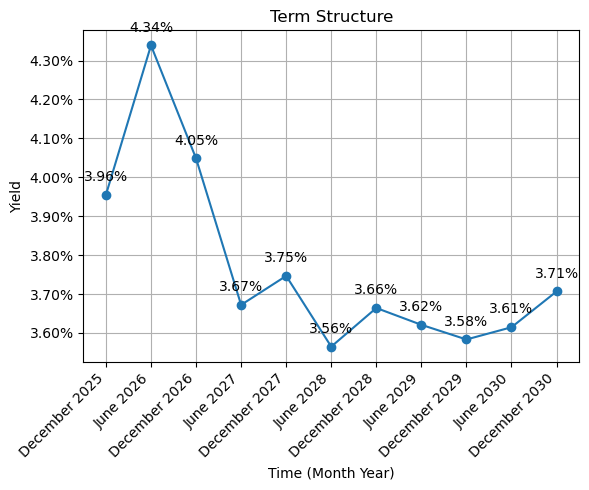

In [101]:
# Plot the entire term structure

x_labels = [
    "December 2025",
    "June 2026",
    "December 2026",
    "June 2027",
    "December 2027",
    "June 2028",
    "December 2028",
    "June 2029",
    "December 2029",
    "June 2030",
    "December 2030"
]

y_vals = [BEY1, BEY2, BEY3, BEY4, BEY5, BEY6, BEY7, BEY8, BEY9, BEY10, BEY11]

plot_term_structure(x_labels, y_vals)

In [102]:
# Convert data fra Term Structure plot to numbers in an array
BEY = np.array(y_vals)
semi_yield = BEY/2

# Create a vector to store all forward rates
N = len(semi_yield)
forward_semi = np.full(N, np.nan)

# There is no forward rate for december 2025
forward_semi[0] = np.nan

# Create 'for loop' to calculate forward rates
for i in range (1, N):
    forward_semi[i] = ((1 + semi_yield[i])**(i+1)) / ((1 + semi_yield[i-1])**i) - 1

forward_BEY = forward_semi * 2


print(forward_BEY)
print(forward_semi)

[       nan 0.04723591 0.03468933 0.02546886 0.04044586 0.02658315
 0.04261329 0.03318468 0.03281961 0.03897482 0.0462829 ]
[       nan 0.02361795 0.01734467 0.01273443 0.02022293 0.01329158
 0.02130665 0.01659234 0.0164098  0.01948741 0.02314145]


In [103]:
f_12 = (1+r2)/(1+r1) - 1
print(round(f_12*100, 5))

2.28589


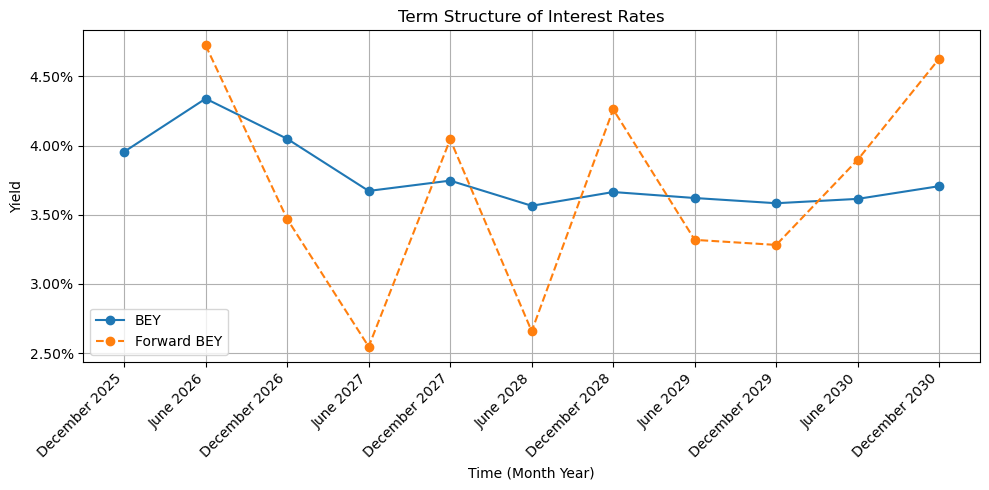

In [104]:
def plot_term_structure_with_forwards(labels, spot_values, forward_values, title="Term Structure of Interest Rates"):
    """
    labels: list of strings
    spot_values: list of spot yields (in decimals)
    forward_values: list of forward yields (in decimals)
    """
    plt.figure(figsize=(10,5))

    # Plot spot curve
    plt.plot(labels, spot_values, marker="o", linestyle="-", label="BEY")

    # Plot forward curve
    plt.plot(labels, forward_values, marker="o", linestyle="--", label="Forward BEY")

    # Format
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    plt.title(title)
    plt.xlabel("Time (Month Year)")
    plt.ylabel("Yield")
    plt.grid(True)
    plt.xticks(rotation=45, ha="right")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_term_structure_with_forwards(x_labels, BEY, forward_BEY)
